In [2]:
from tensorflow.keras import Model,Input, Sequential
from tensorflow.keras import layers, utils, models
from tensorflow.keras import backend as K
from tensorflow.image import resize
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def apply_layer(inputs, cur_layer):
    return [cur_layer(input) for input in inputs]

In [5]:
sizes = []
input_tensor = Input((224,224,1),name='input')
sizes.append(input_tensor)
sizes.append(layers.MaxPooling2D((2,2), padding='same',name='optional_pooling_1')(sizes[0]))
sizes.append(layers.MaxPooling2D((3,3), padding='same',name='optional_pooling_2')(sizes[0]))
sizes.append(layers.MaxPooling2D((4,4), padding='same',name='optional_pooling_3')(sizes[0]))
sizes.append(layers.MaxPooling2D((5,5), padding='same',name='optional_pooling_4')(sizes[0]))
sizes.append(layers.MaxPooling2D((6,6), padding='same',name='optional_pooling_5')(sizes[0]))
sizes.append(layers.MaxPooling2D((7,7), padding='same',name='optional_pooling_6')(sizes[0]))
sizes.append(layers.MaxPooling2D((8,8), padding='same',name='optional_pooling_7')(sizes[0]))
# intuitively more reasonable to do average pooling
# optimally we can create some sort of poolinglayer with non-integer stride (consider upsampling)
cur_layer = layers.Conv2D(32, (3,3), activation='relu', padding='valid',name='conv_1')
# you should design your top layers assuming the lowest resolution
sizes = apply_layer(sizes,cur_layer)
cur_layer = layers.MaxPooling2D((2,2), padding='valid',name='pooling_1')
sizes = apply_layer(sizes,cur_layer)
cur_layer = layers.Conv2D(64, (3,3), activation='relu', padding='valid', name='conv_2')
sizes = apply_layer(sizes,cur_layer)
cur_layer = layers.MaxPooling2D((2,2), padding='valid',name='pooling_2')
sizes = apply_layer(sizes,cur_layer)
cur_layer = layers.Conv2D(32, (3,3), activation='relu', padding='valid', name='conv_3')
sizes = apply_layer(sizes,cur_layer)
cur_layer = layers.Conv2D(16, (3,3), activation='relu', padding='valid', name='conv_4')
sizes = apply_layer(sizes,cur_layer)
cur_layer = layers.Lambda(lambda x : K.max(K.max(x,axis=2),axis=1), name='max')
sizes = apply_layer(sizes,cur_layer)
cur_layer = layers.Flatten()
sizes = apply_layer(sizes,cur_layer)
conv_output = layers.Concatenate()(sizes)

cur_tensor = layers.Dense(64, activation='relu', name='dense_1')(conv_output)
cur_tensor = layers.Dense(32, activation='relu', name='dense_2')(cur_tensor)
output_tensor = layers.Dense(10, activation='softmax', name='output')(cur_tensor)

model = Model(input_tensor,output_tensor)

Model: "functional_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
optional_pooling_1 (MaxPooling2 (None, 112, 112, 1)  0           input[0][0]                      
__________________________________________________________________________________________________
optional_pooling_2 (MaxPooling2 (None, 75, 75, 1)    0           input[0][0]                      
__________________________________________________________________________________________________
optional_pooling_3 (MaxPooling2 (None, 56, 56, 1)    0           input[0][0]                      
_______________________________________________________________________________________

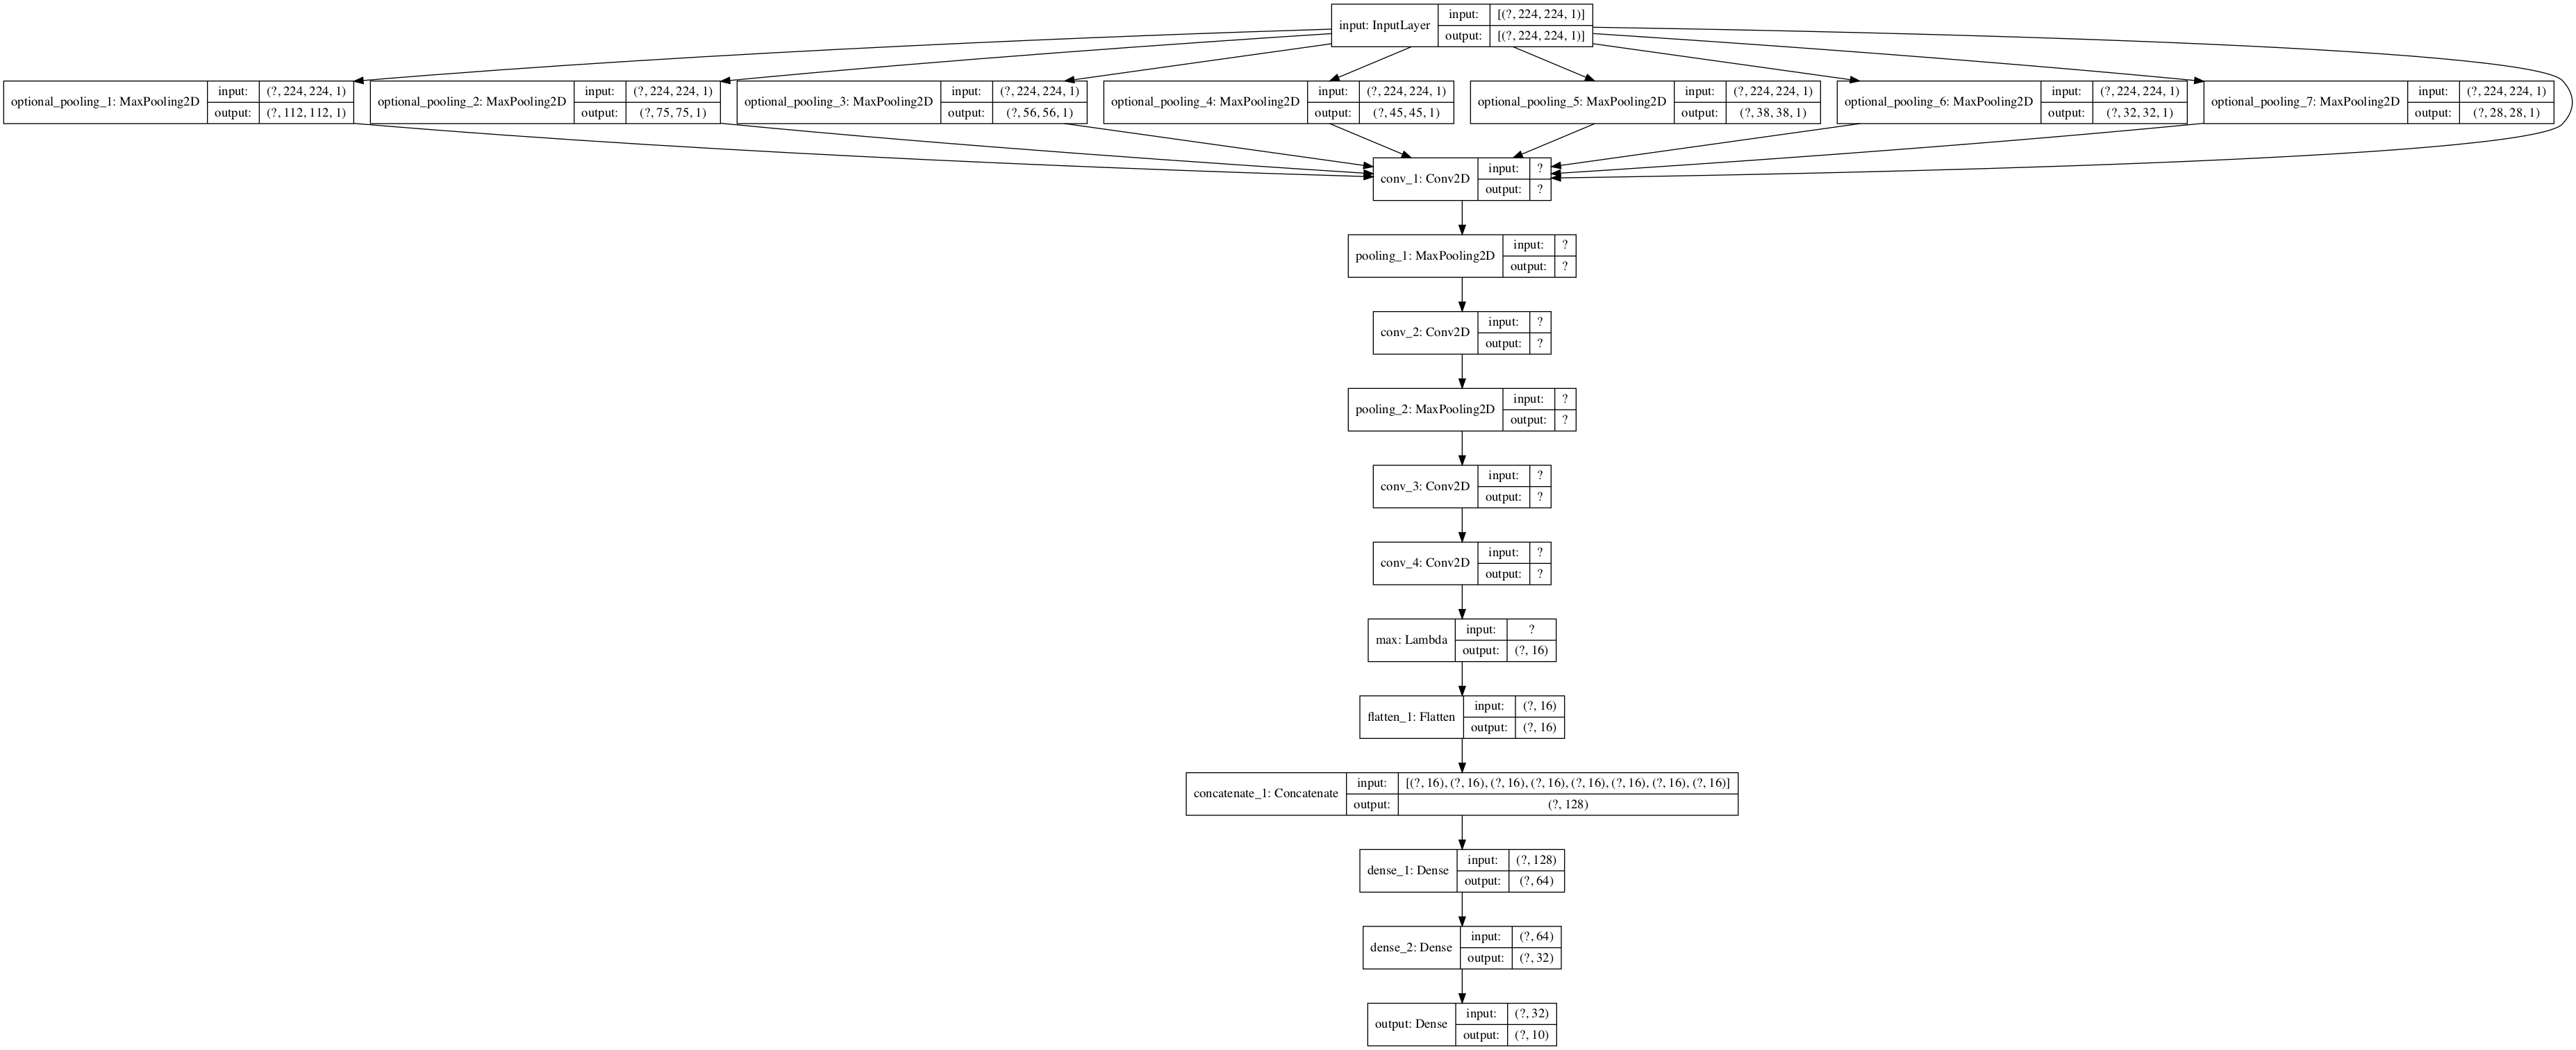

In [6]:
model.summary()
utils.plot_model(model, to_file='simple_test.png',show_shapes=True)

In [7]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

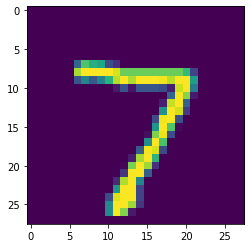

In [61]:
from tensorflow.keras.datasets import mnist
(orig_train_data, orig_train_labels), (test_data, test_labels) = mnist.load_data()
train_data = orig_train_data[:5000]
train_labels = orig_train_labels[:5000]
train_data = train_data[...,np.newaxis]/255
test_data = test_data[...,np.newaxis]/255
plt.imshow(test_data[0])
plt.show()
train_data = resize(train_data, (224,224), method='nearest')
test_data = resize(test_data,(224,224), method='nearest')

(5000, 224, 224, 1)


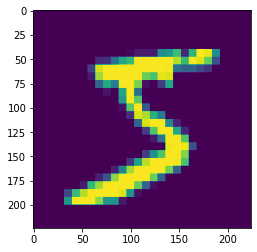

In [56]:
print(train_data.shape)
plt.imshow(train_data[0])
plt.show()

In [11]:
model.fit(train_data, train_labels, epochs=10, batch_size=128,validation_split=0.15)

Epoch 1/10
34/34 [==============================] - 151s 4s/step - loss: 2.0026 - sparse_categorical_accuracy: 0.2701 - val_loss: 1.3255 - val_sparse_categorical_accuracy: 0.5560
Epoch 2/10
 5/34 [===>..........................] - ETA: 1:29 - loss: 1.2047 - sparse_categorical_accuracy: 0.5828

KeyboardInterrupt: 

In [75]:
model.save('simple_model.h5')

In [13]:
loss, acc = model.evaluate(test_data,test_labels)
print(loss, acc)

313/313 [==============================] - 99s 316ms/step - loss: 0.0904 - sparse_categorical_accuracy: 0.9716
0.0903625339269638 0.9715999960899353


In [12]:
model = models.load_model('simple_model.h5')

In [76]:
model2 = Sequential([
    layers.MaxPooling2D((8,8), padding='same',name='pre_pooling', input_shape=(224,224,1)),
    layers.Convolution2D(32, (3,3), activation='relu', name = 'conv1',input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2), padding='valid',name='pooling1'),
    layers.Conv2D(64, (3,3), activation='relu', name='conv2'),
    layers.MaxPooling2D((2,2), padding='valid',name='pooling2'),
    layers.Conv2D(32, (3,3), activation='relu', name='conv3'),
    layers.Conv2D(16, (3,3), activation='relu', name='conv4'),
    layers.Lambda(lambda x : K.max(K.max(x,axis=2),axis=1), name='max'),
    layers.Flatten(),
    layers.Dense(64, activation='relu', name='dense1'),
    layers.Dense(32, activation='relu', name='dense2'),
    layers.Dense(10, activation='softmax')
])
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [77]:
model2.fit(train_data,train_labels,epochs=10,batch_size=128,validation_split=0.15)

Epoch 1/10
34/34 [==============================] - 6s 182ms/step - loss: 1.9777 - sparse_categorical_accuracy: 0.3553 - val_loss: 1.1348 - val_sparse_categorical_accuracy: 0.6573
Epoch 2/10
34/34 [==============================] - 4s 107ms/step - loss: 0.7383 - sparse_categorical_accuracy: 0.7666 - val_loss: 0.4821 - val_sparse_categorical_accuracy: 0.8427
Epoch 3/10
34/34 [==============================] - 4s 113ms/step - loss: 0.3994 - sparse_categorical_accuracy: 0.8779 - val_loss: 0.3531 - val_sparse_categorical_accuracy: 0.8813
Epoch 4/10
34/34 [==============================] - 4s 106ms/step - loss: 0.3165 - sparse_categorical_accuracy: 0.9040 - val_loss: 0.2558 - val_sparse_categorical_accuracy: 0.9213
Epoch 5/10
34/34 [==============================] - 3s 98ms/step - loss: 0.2329 - sparse_categorical_accuracy: 0.9294 - val_loss: 0.1980 - val_sparse_categorical_accuracy: 0.9360
Epoch 6/10
34/34 [==============================] - 3s 99ms/step - loss: 0.1911 - sparse_categorical_

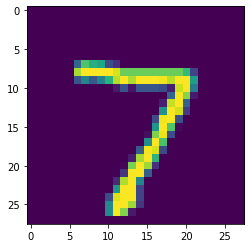

In [58]:
model3 = Sequential([
    layers.MaxPooling2D((8,8), padding='same',name='pool1', input_shape=(224,224,1))
])
model3.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
preds = model3.predict(test_data[0][np.newaxis,...])

plt.imshow(preds.reshape(28,28))
plt.show()

In [72]:
pre_orig_size_train_data = orig_train_data[5000:6000]
orig_size_train_labels = orig_train_labels[5000:6000]
orig_size_train_data = np.zeros((1000,224,224,1))
orig_size_train_data[:,112:140,112:140,:] = pre_orig_size_train_data[...,np.newaxis]

In [81]:
model2.fit(orig_size_train_data,orig_size_train_labels,epochs=10,batch_size=128,validation_split=0.15)
loss, acc = model2.evaluate(test_data,test_labels)
print(loss, acc)

Epoch 1/10
7/7 [==============================] - 1s 89ms/step - loss: 1.9482 - sparse_categorical_accuracy: 0.3247 - val_loss: 1.8958 - val_sparse_categorical_accuracy: 0.3133
Epoch 2/10
7/7 [==============================] - 1s 77ms/step - loss: 1.9188 - sparse_categorical_accuracy: 0.3435 - val_loss: 1.9160 - val_sparse_categorical_accuracy: 0.3200
Epoch 3/10
7/7 [==============================] - 1s 76ms/step - loss: 1.8960 - sparse_categorical_accuracy: 0.3424 - val_loss: 1.8718 - val_sparse_categorical_accuracy: 0.3000
Epoch 4/10
7/7 [==============================] - 1s 99ms/step - loss: 1.8711 - sparse_categorical_accuracy: 0.3541 - val_loss: 1.8601 - val_sparse_categorical_accuracy: 0.3000
Epoch 5/10
7/7 [==============================] - 1s 79ms/step - loss: 1.8552 - sparse_categorical_accuracy: 0.3600 - val_loss: 1.8859 - val_sparse_categorical_accuracy: 0.3000
Epoch 6/10
7/7 [==============================] - 1s 82ms/step - loss: 1.8482 - sparse_categorical_accuracy: 0.3518

In [83]:
model.fit(orig_size_train_data,orig_size_train_labels,epochs=2,batch_size=128,validation_split=0.15)
loss, acc = model.evaluate(test_data,test_labels)
print(loss, acc)

Epoch 1/2
7/7 [==============================] - 25s 4s/step - loss: 97.4473 - sparse_categorical_accuracy: 0.2459 - val_loss: 55.1087 - val_sparse_categorical_accuracy: 0.3200
Epoch 2/2
313/313 [==============================] - 104s 333ms/step - loss: 1.6727 - sparse_categorical_accuracy: 0.3721
1.6727482080459595 0.37209999561309814


In [59]:
outputs = [layer.output for layer in model.layers[0:8]]
model4 = Model(model.input, outputs)
model4.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

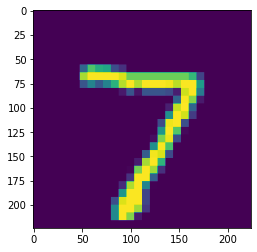

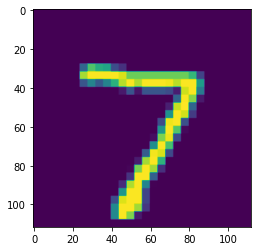

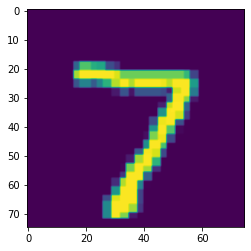

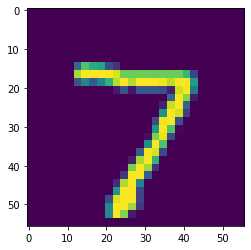

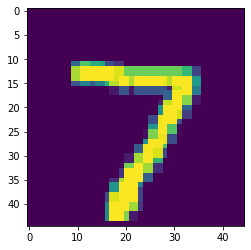

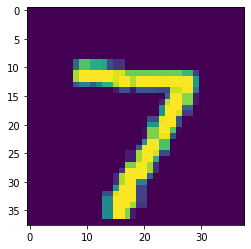

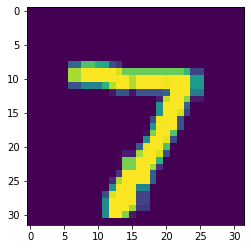

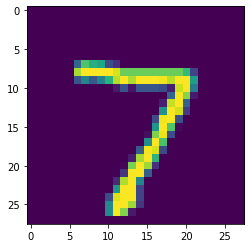

In [60]:
preds = model4.predict(test_data[0][np.newaxis,...])
preds = [np.squeeze(pred) for pred in preds]
for pred in preds:
    plt.imshow(pred)
    plt.show()

In [52]:
outputs2 = [model.get_layer('conv_4').get_output_at(i) for i in range(8)]
model4 = Model(model.input, outputs2)
model4.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

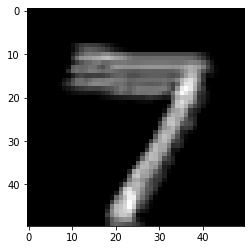

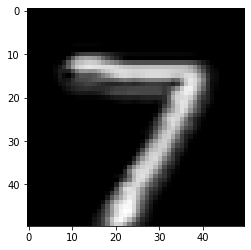

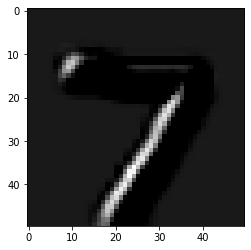

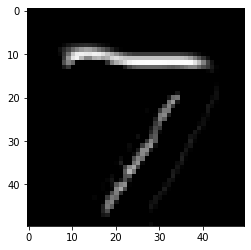

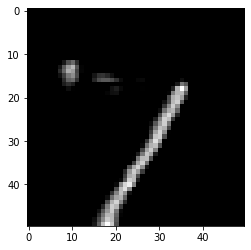

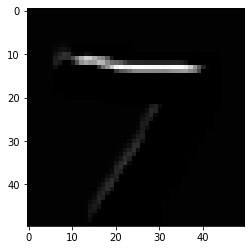

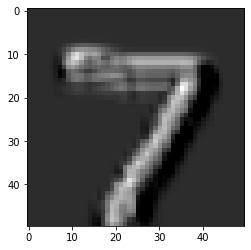

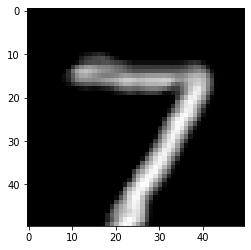

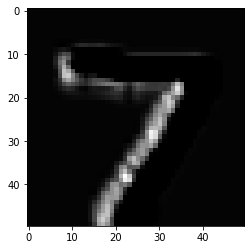

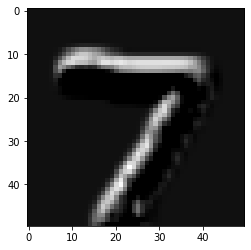

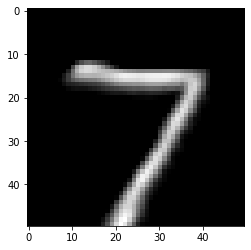

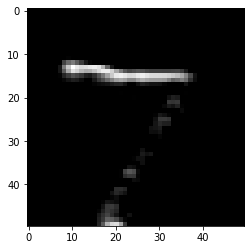

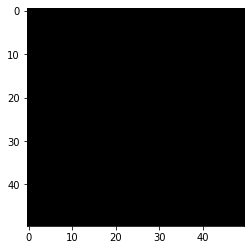

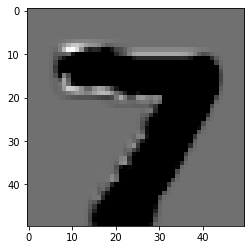

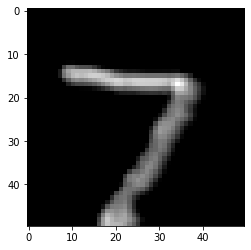

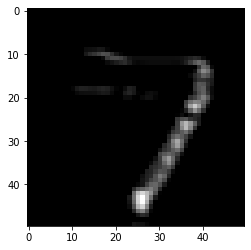

----------


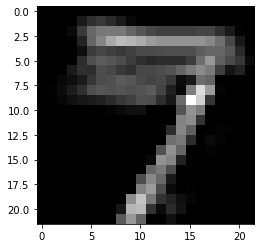

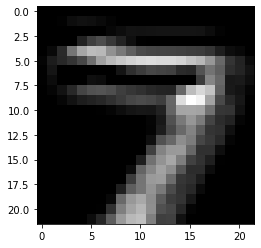

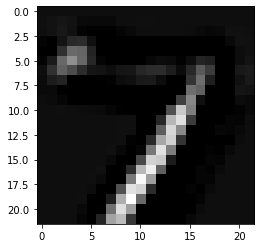

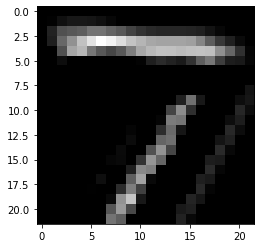

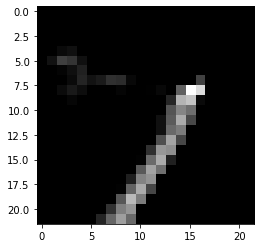

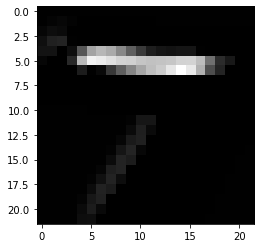

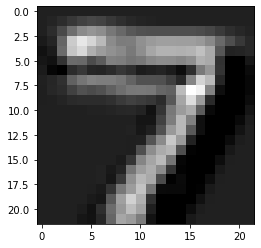

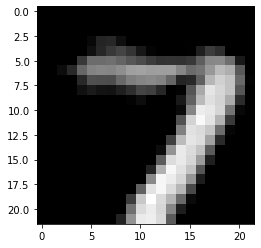

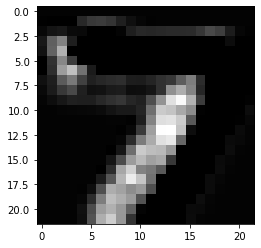

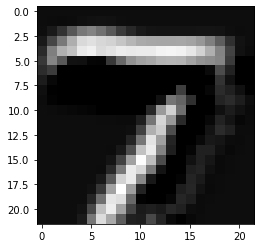

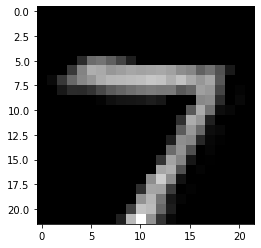

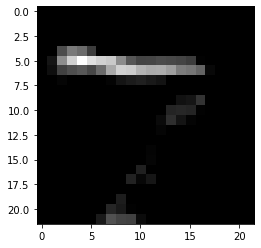

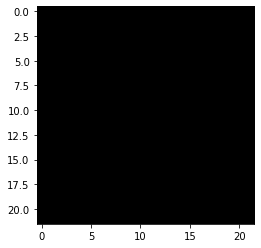

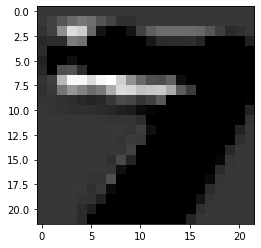

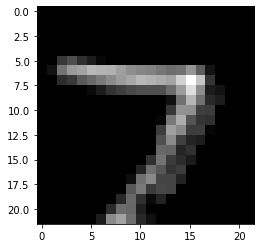

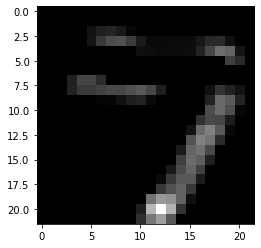

----------


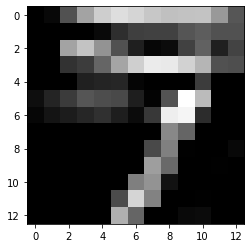

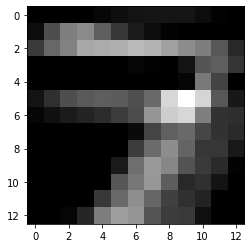

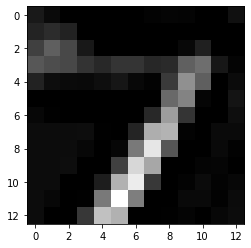

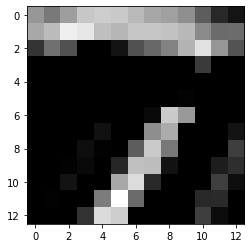

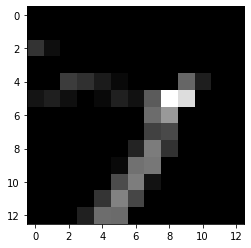

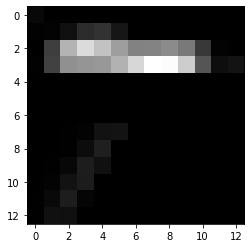

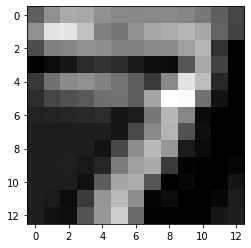

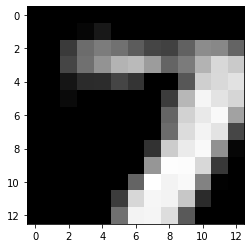

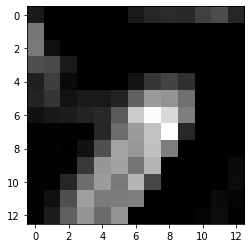

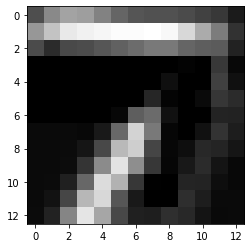

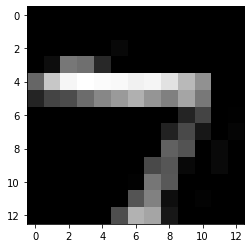

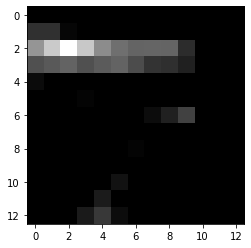

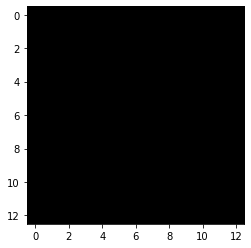

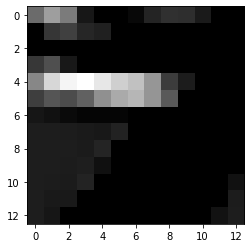

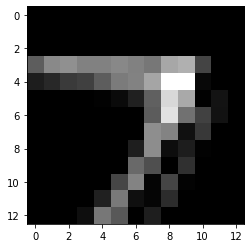

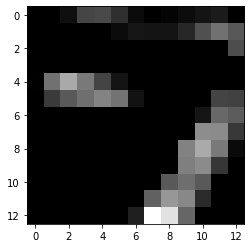

----------


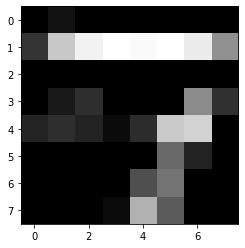

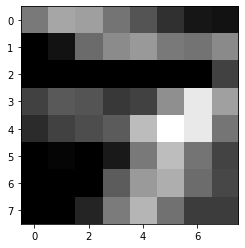

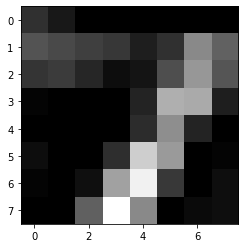

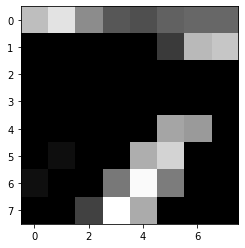

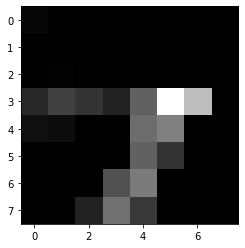

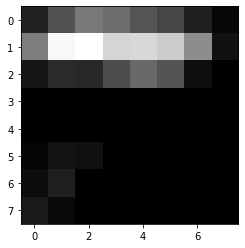

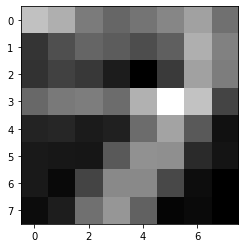

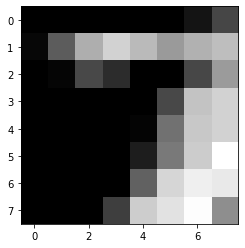

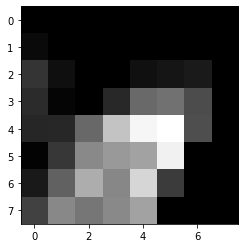

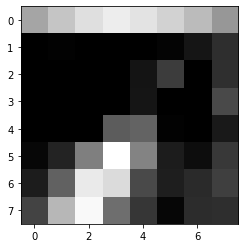

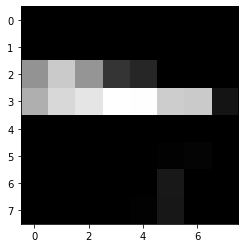

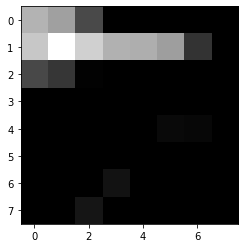

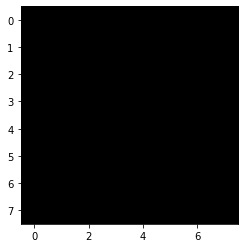

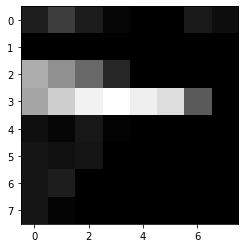

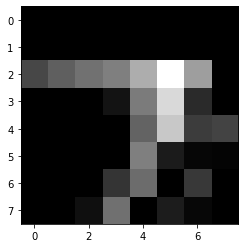

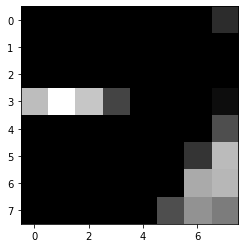

----------


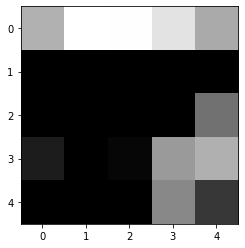

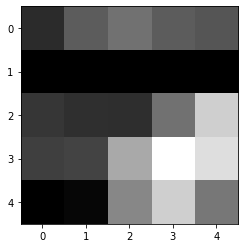

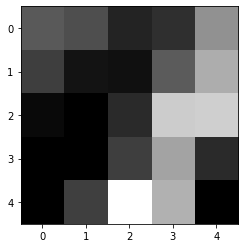

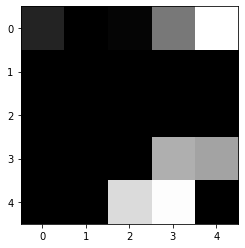

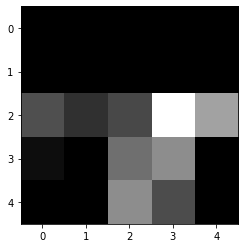

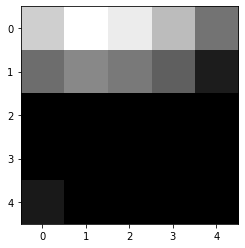

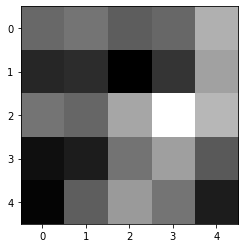

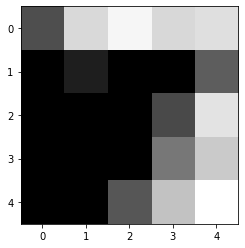

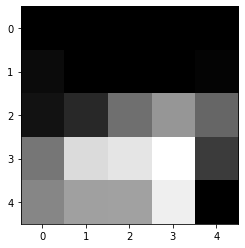

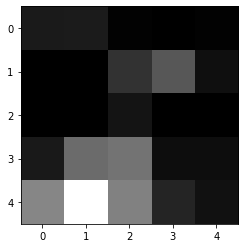

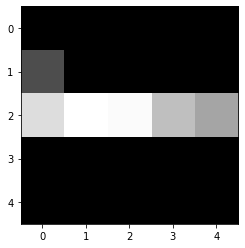

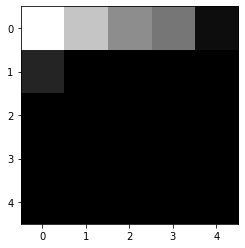

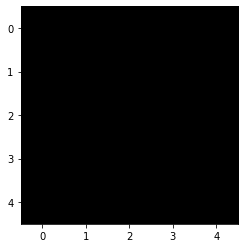

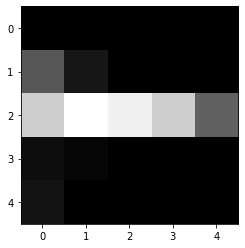

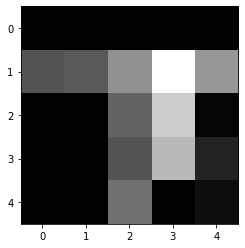

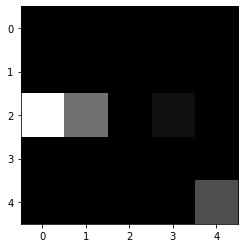

----------


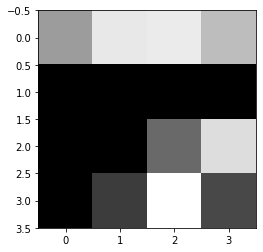

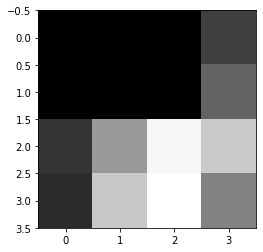

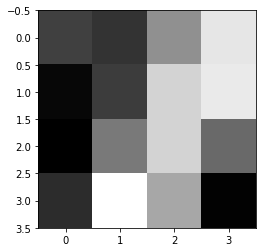

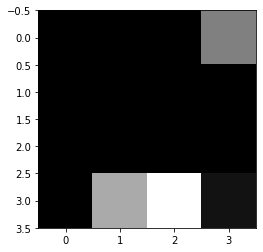

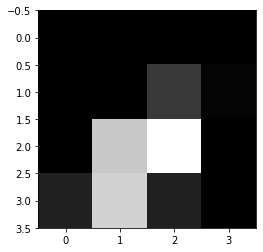

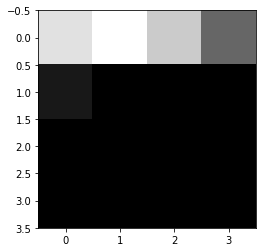

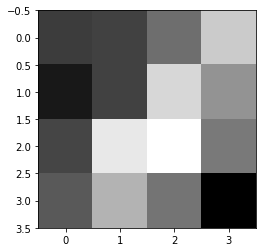

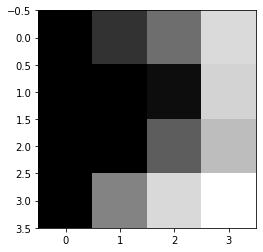

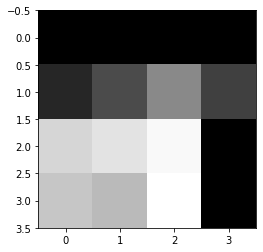

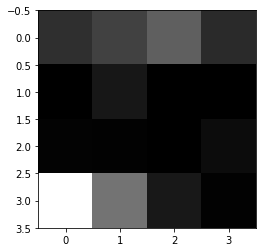

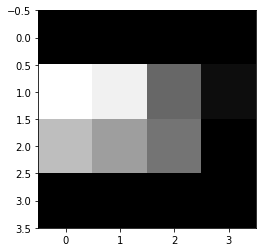

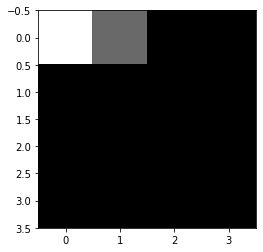

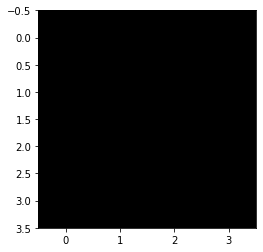

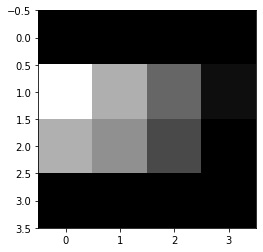

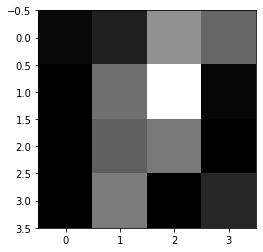

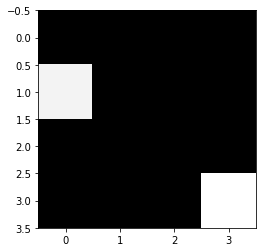

----------


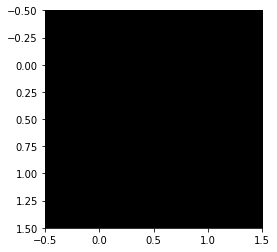

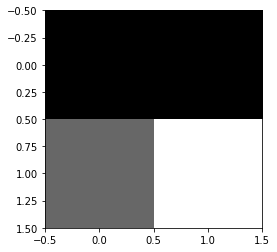

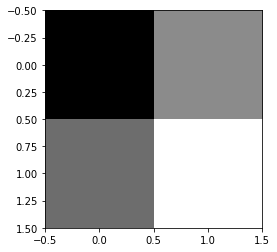

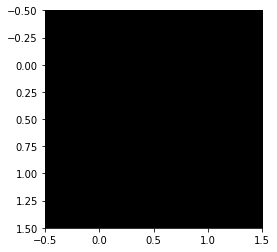

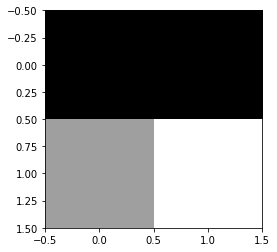

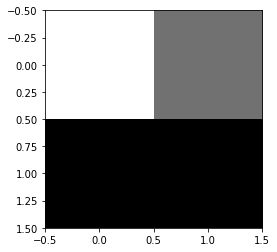

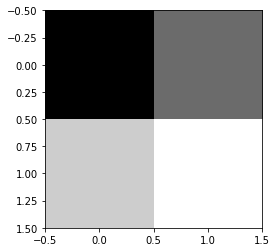

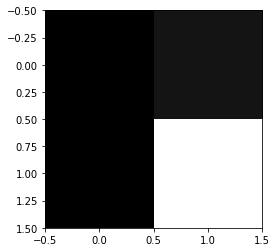

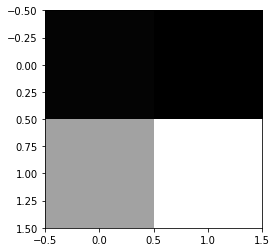

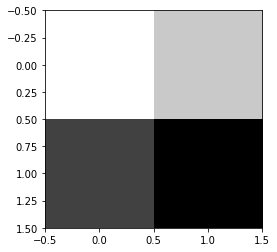

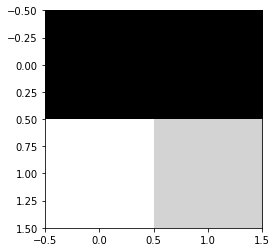

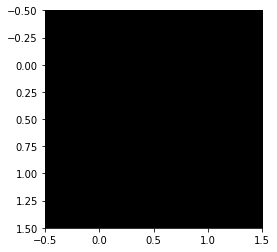

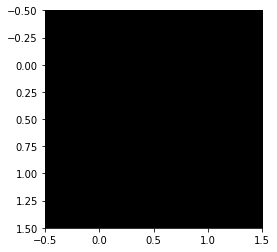

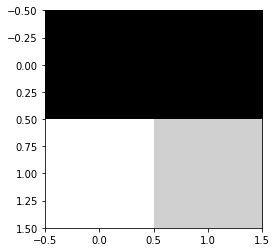

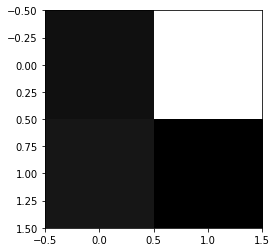

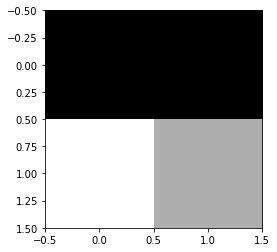

----------


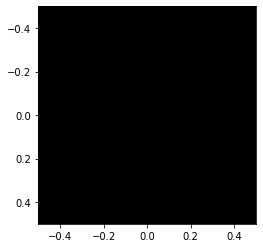

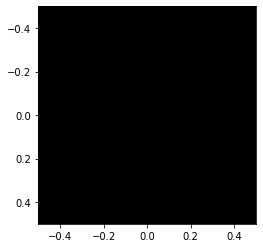

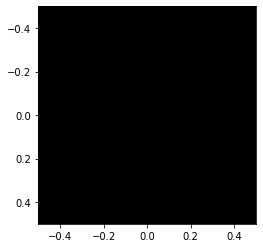

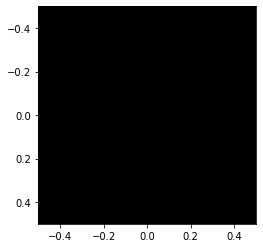

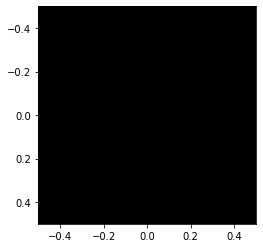

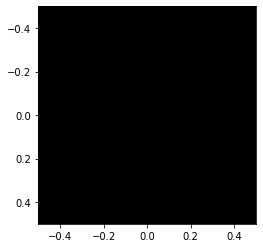

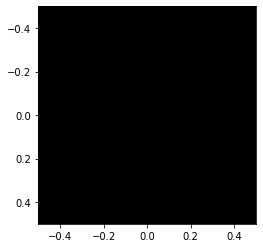

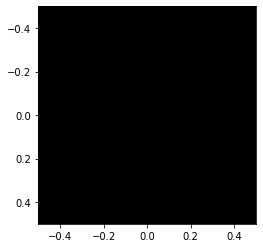

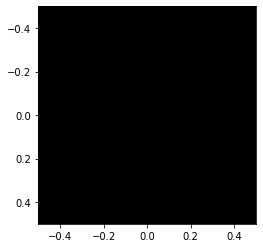

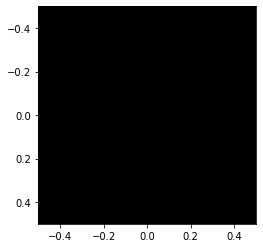

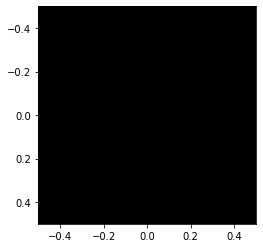

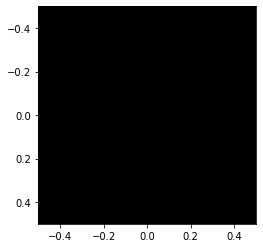

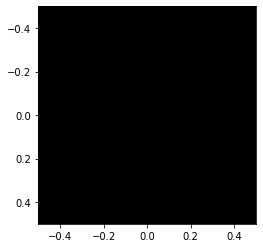

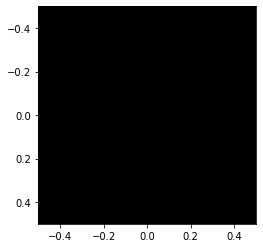

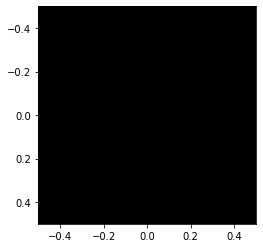

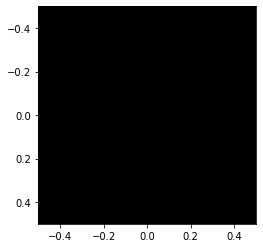

----------


In [54]:
preds = model4.predict(test_data[0][np.newaxis,...])
preds = [pred[0,...] for pred in preds]
for pred in preds:
    for i in range(16):
        plt.imshow(pred[...,i],cmap='gray')
        plt.show()
    print('----------')